In [15]:
import pandas as pd
import requests
import os
import numpy as np

# Amtlicher Gemeindeschluessel:
# https://www.riserid.eu/data/user_upload/downloads/info-pdf.s/Diverses/Liste-Amtlicher-Gemeindeschluessel-AGS-2015.pdf
# Dessau Rosslau: 15001000


"""
Queries the zensus database and saves the result to data_raw
"""
try:
    url = 'https://ergebnisse.zensus2011.de/auswertungsdb/download?csv=dynTable&tableHash=statUnit=WOHNUNG;absRel=ANZAHL;ags=150010000000;agsAxis=X;yAxis=BAUJAHR_MZ,ZAHLWOHNGN_HHG,WOHNFLAECHE_10S&locale=DE'
    r = requests.get(url)
    open('zensus_alter_anzahlwohnungen_flaeche_anzahl.csv', 'wb').write(r.content)
except:
    print('Download failed')

## Get zensus data from database

In [39]:
"""
Calculates the total area by building type and age

"""
zensus_data = pd.read_csv('zensus_alter_anzahlwohnungen_flaeche_anzahl.csv',
                              delimiter=';', skiprows=6, skipfooter=7, encoding='ISO-8859-14',
                              names=['Baujahr', 'Gebauede_Anzahl_Wohnungen', 'Groesse_m2', 'Anzahl'])

# clean data
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2'].str[-3:]
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace('ehr', 200)
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace('amt', np.nan)
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].astype('float') - 4.5
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace(195.5, 200)
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace(25.5, 20)

zensus_data['Anzahl_cleaned'] = zensus_data['Anzahl'].str.replace('(', '').str.replace(')', '').replace(['-'], np.nan).astype('float')

# calculate total area
zensus_data['Flaeche'] = zensus_data['Anzahl_cleaned'] * zensus_data['Groesse_m2_cleaned']
# zensus_data.loc[zensus_data['Baujahr']=='Insgesamt'].loc[zensus_data['Gebauede_Anzahl_Wohnungen']=='1 Wohnung']

/home/local/RL-INSTITUT/jann.launer/Desktop/oemof_repos/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  import sys


In [40]:
zensus_data_grouped = zensus_data.groupby(['Baujahr', 'Gebauede_Anzahl_Wohnungen'])['Flaeche'].sum().unstack()
zensus_data_grouped

Gebauede_Anzahl_Wohnungen,1 Wohnung,13 und mehr Wohnungen,2 Wohnungen,3 - 6 Wohnungen,7 - 12 Wohnungen,Insgesamt
Baujahr,,,,,,
1919 - 1948,585121.5,21441.0,149374.0,284392.0,139206.5,1179535.0
1949 - 1978,148198.5,143652.0,20235.5,128121.0,523645.0,963852.0
1979 - 1986,65599.0,37623.5,2332.5,1092.0,348737.0,455384.0
1987 - 1990,21213.5,23396.0,1044.0,4747.0,76872.0,127272.5
1991 - 1995,98094.5,19492.5,11020.5,27340.5,26598.0,182546.0
1996 - 2000,163397.5,44839.5,20887.0,38423.0,61887.0,329434.0
2001 - 2004,67749.0,9953.5,3396.5,8364.0,7222.5,96685.5
2005 - 2008,30359.5,4345.0,2249.0,2767.5,2177.5,41898.5
2009 und später,9847.5,0.0,1875.5,2264.0,2401.0,16388.0


In [37]:
# sort
columns = zensus_data_grouped.columns
columns = columns[[0, 2, 3, 4, 1, 5]]
zensus_data_grouped_sorted = zensus_data_grouped[columns]
index = zensus_data_grouped_sorted.index[[10,0,1,2,3,4,5,6,7,8,9]]
zensus_data_grouped_sorted = zensus_data_grouped_sorted.reindex(index)
zensus_data_grouped_sorted

Gebauede_Anzahl_Wohnungen,1 Wohnung,2 Wohnungen,3 - 6 Wohnungen,7 - 12 Wohnungen,13 und mehr Wohnungen,Insgesamt
Baujahr,,,,,,
Vor 1919,182628.5,74096.5,147633.0,126362.0,10100.0,540820.0
1919 - 1948,585121.5,149374.0,284392.0,139206.5,21441.0,1179535.0
1949 - 1978,148198.5,20235.5,128121.0,523645.0,143652.0,963852.0
1979 - 1986,65599.0,2332.5,1092.0,348737.0,37623.5,455384.0
1987 - 1990,21213.5,1044.0,4747.0,76872.0,23396.0,127272.5
1991 - 1995,98094.5,11020.5,27340.5,26598.0,19492.5,182546.0
1996 - 2000,163397.5,20887.0,38423.0,61887.0,44839.5,329434.0
2001 - 2004,67749.0,3396.5,8364.0,7222.5,9953.5,96685.5
2005 - 2008,30359.5,2249.0,2767.5,2177.5,4345.0,41898.5


In [38]:
print(zensus_data_grouped[columns[:-1]].sum(axis=1) == zensus_data_grouped['Insgesamt'])
print(zensus_data_grouped.iloc[0:10].sum(axis=0) == zensus_data_grouped.iloc[10])

Baujahr
1919 - 1948        True
1949 - 1978        True
1979 - 1986        True
1987 - 1990        True
1991 - 1995        True
1996 - 2000        True
2001 - 2004        True
2005 - 2008        True
2009 und später    True
Insgesamt          True
Vor 1919           True
dtype: bool
Gebauede_Anzahl_Wohnungen
1 Wohnung                False
13 und mehr Wohnungen    False
2 Wohnungen              False
3 - 6 Wohnungen          False
7 - 12 Wohnungen         False
Insgesamt                False
dtype: bool


## Load heat demand per area from file

In [149]:
heat_demand_per_area = pd.read_csv('data/dena_heat_demand_per_area.csv', index_col='year')
heat_demand_per_area = heat_demand_per_area.stack()
heat_demand_per_area.index = pd.MultiIndex.from_tuples([(x[0], int(x[1].replace('mehr als 21', '21')[:2].replace(' ', ''))) for x in heat_demand_per_area.index])

In [150]:
heat_demand_per_area.loc['1919-1948', 21]

118

In [153]:
heat_demand_per_area.index.levels[0]
num_flats_list = [x for x in range(1,22)]

In [154]:
for year in heat_demand_per_area.index.levels[0]:
    for num_flats in num_flats_list:
        print(year)
        print(num_flats)
        if (year, num_flats) not in heat_demand_per_area.index:
            heat_demand_per_area.loc[year, num_flats] = heat_demand_per_area.loc[year, num_flats-1]
            print('  ', heat_demand_per_area.loc[year, num_flats])
        else:
            print('  ', heat_demand_per_area.loc[year, num_flats])

1918 und davor
1
   170
1918 und davor
2
   160
1918 und davor
3
   143
1918 und davor
4
   143
1918 und davor
5
   143
1918 und davor
6
   143
1918 und davor
7
   143
1918 und davor
8
   135
1918 und davor
9
   135
1918 und davor
10
   135
1918 und davor
11
   135
1918 und davor
12
   135
1918 und davor
13
   120
1918 und davor
14
   120
1918 und davor
15
   120
1918 und davor
16
   120
1918 und davor
17
   120
1918 und davor
18
   120
1918 und davor
19
   120
1918 und davor
20
   120
1918 und davor
21
   120
1919-1948
1
   170
1919-1948
2
   160
1919-1948
3
   140
1919-1948
4
   140
1919-1948
5
   140
1919-1948
6
   140
1919-1948
7
   140
1919-1948
8
   136
1919-1948
9
   136
1919-1948
10
   136
1919-1948
11
   136
1919-1948
12
   136
1919-1948
13
   118
1919-1948
14
   118
1919-1948
15
   118
1919-1948
16
   118
1919-1948
17
   118
1919-1948
18
   118
1919-1948
19
   118
1919-1948
20
   118
1919-1948
21
   118
1949-1978
1
   169
1949-1978
2
   160
1949-1978
3
   143
1949-1978
4
   1

In [158]:
heat_demand_per_area = heat_demand_per_area.sort_index()

In [162]:
heat_demand_per_area.unstack()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
1918 und davor,170,160,143,143,143,143,143,135,135,135,...,135,120,120,120,120,120,120,120,120,120
1919-1948,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1949-1978,169,160,143,143,143,143,143,137,137,137,...,137,122,122,122,122,122,122,122,122,122
1979-1990,145,122,122,122,122,122,122,138,138,138,...,138,120,120,120,120,120,120,120,120,120
1991-2000,119,102,102,102,102,102,102,100,100,100,...,100,95,95,95,95,95,95,95,95,120
2001-2005,82,61,80,80,80,80,80,80,80,80,...,80,60,60,60,60,60,60,60,60,60


,-----------------------

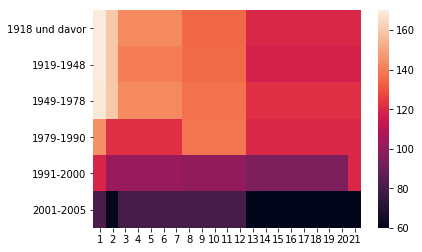

In [164]:
%matplotlib inline
import seaborn as sns
sns.heatmap(heat_demand_per_area.unstack(), annot=False)

In [165]:
heat_demand_per_area.loc[1919:1948].mean()
heat_demand_per_area.loc[1949:1978].mean()
heat_demand_per_area.loc[1979:1986].mean()
heat_demand_per_area.loc[1987:1990].mean()
heat_demand_per_area.loc[1991:1995]
heat_demand_per_area.loc[1996:2000]
heat_demand_per_area.loc[2001]

TypeError: Level type mismatch: 1919

In [46]:
zensus_data_grouped.index

Index(['1919 - 1948', '1949 - 1978', '1979 - 1986', '1987 - 1990',
       '1991 - 1995', '1996 - 2000', '2001 - 2004', '2005 - 2008',
       '2009 und später', 'Insgesamt', 'Vor 1919'],
      dtype='object', name='Baujahr')